This is going to be the similar mass case with circular orbit and then implement Df equation with that


How this Jupyter Notebook will look like:
- Initialize the packets
- initial conditions
- dictate the circular orbit
- forloop
- effective energy plot (coming soon)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import solve_ivp
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math
from functools import partial
import pickle

In [26]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 12 

This is the tests that were done in Kris' github:

In [27]:
a_0 = 2.95 
b_0 = 0.596
mstar_tot = 1e11 * u.Msun
r_eff = (a_0*(mstar_tot/(1.e6*u.Msun))**b_0)* u.pc
print(r_eff)

2817.2281287632354 pc


In [28]:
m1 = 4e8 * u.Msun
rb = (m1/mstar_tot)**(1./3.)*r_eff
print("Binary radius is:", rb)
dyn_hard = (((rb/r_eff)**3)*r_eff).to(u.pc)
print(dyn_hard)

Binary radius is: 447.20708952331626 pc
11.268912515052946 pc


In [29]:
# region Code Snippet 1: IC's
G = const.G.to(u.pc**3/(u.kg*u.yr**2)) #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A
m2=4e8 * const.M_sun #mass of black hole B


sep = 430 * u.pc #3kpc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays

r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc

#Semi-major axis
a = (0.5 * (sep))

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)

#orbital veloctiy
# orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
# v = np.sqrt((const.G * (m1)) / r.to(u.m)).to(u.km/u.s)
v_circ = (np.sqrt((G*m1*(sep/2))/(sep)**2)).value #should be around 44
print(r1)
#V_i
v1_initial1=[0,v_circ, 0] *u.pc/u.yr
v2_inital1=[0,-v_circ,0] *u.pc/u.yr #km/s

# v_df_fixed = (((np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s)).to(u.pc / u.yr).value)

v_df_fixed = (126 * u.km/ u.s).to(u.pc / u.yr).value #should be around 126


# pi4 = (np.sqrt(2) / 2) * v_df_fixed
v1_df = np.array([ 0, v_df_fixed, 0]) *u.pc/u.yr
v2_df = np.array([0, -v_df_fixed, 0]) *u.pc/u.yr
print(v1_df, v2_df)
#To arrays
v1=np.array(v1_initial1,dtype="float64") *u.pc/u.yr
v2=np.array(v2_inital1,dtype="float64") *u.pc/u.yr
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

#3 Gyr - 10 kpc

y01 = np.concatenate([
    r1.to_value(u.pc),
    r2.to_value(u.pc),
    v1.to_value(u.pc/u.yr),
    v2.to_value(u.pc/u.yr)
])

y0_df = np.concatenate([
    r1.to_value(u.pc),
    r2.to_value(u.pc),
    v1_df.to_value(u.pc/u.yr),
    v2_df.to_value(u.pc/u.yr)
])


[215.   0.   0.] pc
[0.         0.00012886 0.        ] pc / yr [ 0.         -0.00012886  0.        ] pc / yr


In [30]:
(10**(2.2969)*(m_gal / (10**11 * const.M_sun)))

<Quantity 198.10708149>

Functions

In [31]:
def velocity_dispersion(m_gal_kg):
    """Calculate velocity dispersion in pc/yr using scaling relation"""
    m_gal_ratio = m_gal_kg / (1e11 * const.M_sun.to(u.kg).value)
    v_kms = (10**2.2969) * m_gal_ratio**0.299  # km/s
    v_disp = (v_kms * u.km / u.s).to(u.pc / u.yr)
    return v_disp  # returns Quantity [pc/yr]

def coulomb_logarithm(r_pc, sigma_pc_yr, G_val, m_val):
    """Coulomb logarithm calculation from dimensionless expression"""
    # Convert sigma to float for math expression
    sigma_val = sigma_pc_yr.value
    x = (r_pc * sigma_val**2) / (G_val * m_val)
    return math.log10(x)

def dynamical_friction_acceleration(r_mag_pc, v_vec_pc_yr, ln_Lambda, G_val, m_val):
    """Compute DF acceleration for one object"""
    v_mag = np.linalg.norm(v_vec_pc_yr)
    unit_v = v_vec_pc_yr / v_mag
    a_df_mag = 0.428 * ln_Lambda * ((G_val * (m_val)) / r_mag_pc**2)
    return (-a_df_mag * unit_v)  # returns np.array of shape (3,)

def calculate_DF(G_val, m1_val, m2_val, m_gal_val, r1_vec_pc, r2_vec_pc, v1_vec_pc_yr, v2_vec_pc_yr):
    """Full DF acceleration for two BHs in galaxy frame"""

    sigma_pc_yr = velocity_dispersion(m_gal_val)


    r1_mag_pc = np.linalg.norm(r1_vec_pc)
    r2_mag_pc = np.linalg.norm(r2_vec_pc)


    ln_A1 = coulomb_logarithm(r1_mag_pc, sigma_pc_yr, G_val, m1_val)
    ln_A2 = coulomb_logarithm(r2_mag_pc, sigma_pc_yr, G_val, m2_val)


    a_df1 = dynamical_friction_acceleration(r1_mag_pc, v1_vec_pc_yr, ln_A1, G_val, m1_val)
    a_df2 = dynamical_friction_acceleration(r2_mag_pc, v2_vec_pc_yr, ln_A2, G_val, m2_val)

    return a_df1, a_df2  # both in [pc/yr²] as np.arrays

In [32]:
o = velocity_dispersion(m_gal.value)
print(f'{o}, velocity, dispersion, is the function value and {(198.107081487124 * (u.km / u.s)).to(u.pc/u.yr)} is what the raw conversion from the for loop and they match!')
ln_A1 = coulomb_logarithm(215, o, G.value, m1.value)
print(f'{ln_A1} also matches and it is the coulomb logarithm')
a_d1 = dynamical_friction_acceleration(215, v1, ln_A1, G.value, m1.value)
print(a_d1)
(a_d1 * (u.pc / u.yr**2)).to(u.km/u.s**2)





0.0002026065222185805 pc / yr, velocity, dispersion, is the function value and 0.0002026065222185805 pc / yr is what the raw conversion from the for loop and they match!
0.6906173797913484 also matches and it is the coulomb logarithm
[-0.00000000e+00 -1.15062095e-11 -0.00000000e+00]


<Quantity [-0.00000000e+00, -3.56512603e-13, -0.00000000e+00] km / s2>

In [33]:
# T = 1 * u.Gyr
# N = 500
# delta_t = T/ N


# # dv1bydt= ((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + F_D1
# # dv2bydt= ((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2)  + F_D2
# # dr1bydt = v1  # maybe we don't need df subtraction here
# # dr2bydt = v2
# # r_derivs=np.concatenate((dr1bydt.value,dr2bydt.value))
# # derivs=np.concatenate((r_derivs,dv1bydt.value,dv2bydt.value))

# time_span=np.linspace(0, T, N) #Work on this with Kris' link

Period Test

In [34]:
orbital_period = np.sqrt((4 * (np.pi)**2 / (G * (m1)) * (a**3))).to(u.Myr)

print(orbital_period)

14.766364899677814 Myr


One of the tests to do:



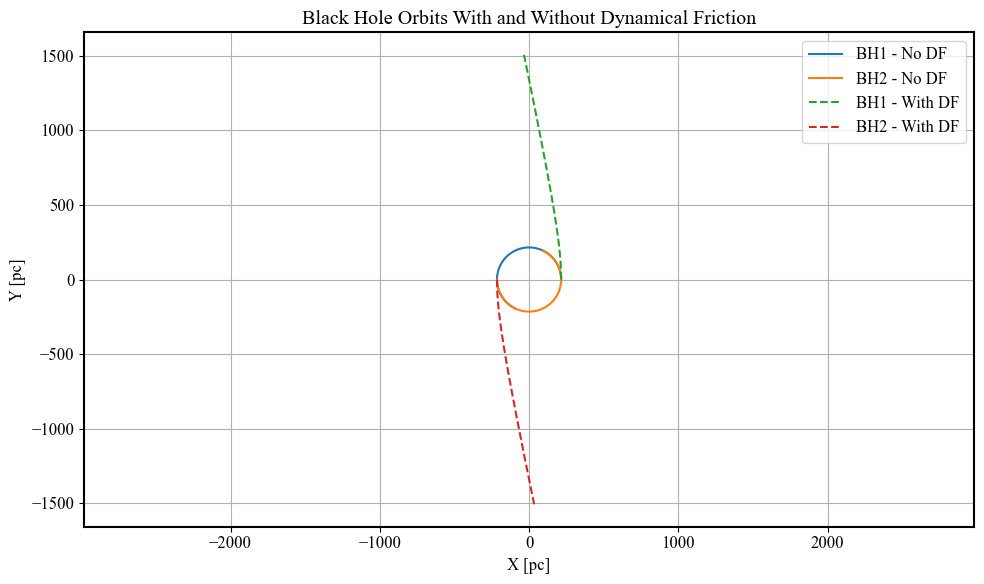

In [35]:
def dydt_trackingforall(t, y, m1, m2, G_, m_gal_, df_on=False):
    r1_ = y[0:3]
    r2_ = y[3:6]
    v1_ = y[6:9]
    v2_ = y[9:12]

    r12 = r2_ - r1_
    r12_mag = np.linalg.norm(r12)

    dv1bydt = (G_ * m2 / r12_mag**3) * r12
    dv2bydt = (G_ * m1 / r12_mag**3) * (-r12)

    a1_df = np.zeros(3)
    a2_df = np.zeros(3)

    if df_on:
        a1_df, a2_df = calculate_DF(G_, m1, m2, m_gal_, r1_, r2_, v1_, v2_)

    a1_total = dv1bydt + a1_df
    a2_total = dv2bydt + a2_df

    return np.concatenate([v1_, v2_, a1_total, a2_total])




t_i = 0.0  # yr
t_f = (20 * u.Myr).to(u.yr).value  # in yr
t_eval = np.linspace(t_i, t_f, 500)

G_val = G.value  # in pc^3 / (kg * yr^2)
m1_val = m1.to(u.kg).value
m2_val = m2.to(u.kg).value
m_gal_val = m_gal.value

dydt_no_df = partial(dydt_trackingforall, m1=m1_val, m2=m2_val, G_=G_val, m_gal_=m_gal_val, df_on=False)
dydt_df = partial(dydt_trackingforall, m1=m1_val, m2=m2_val, G_=G_val, m_gal_=m_gal_val, df_on=True)

sol_no_df = solve_ivp(dydt_no_df, (t_i, t_f), y01, t_eval=t_eval, method='RK45', rtol=1e-8, atol=1e-8)
sol_df = solve_ivp(dydt_df, (t_i, t_f), y0_df, t_eval=t_eval, method='RK45', rtol=1e-8, atol=1e-8)

def unpack_solution(sol):
    r1_ = sol.y[0:3].T  # shape (N, 3)
    r2_ = sol.y[3:6].T
    v1_ = sol.y[6:9].T
    v2_ = sol.y[9:12].T
    sep = np.linalg.norm(r1_ - r2_, axis=1)
    return r1_, r2_, v1_, v2_, sep


r1_nodf_arr, r2_nodf_arr, v1_nodf_arr, v2_nodf_arr, sep_nodf_arr = unpack_solution(sol_no_df)
r1_df_arr, r2_df_arr, v1_df_arr, v2_df_arr, sep_df_arr = unpack_solution(sol_df)


def compute_forces(G_, m1, m2, m_gal_, r1_arr, r2_arr, v1_arr, v2_arr, df_on=False):
    N = r1_arr.shape[0]
    a_grav1 = np.zeros((N, 3))
    a_grav2 = np.zeros((N, 3))
    a_df1 = np.zeros((N, 3))
    a_df2 = np.zeros((N, 3))
    a_total1 = np.zeros((N, 3))
    a_total2 = np.zeros((N, 3))

    for i in range(N):
        r1_ = r1_arr[i]
        r2_ = r2_arr[i]
        v1_ = v1_arr[i]
        v2_ = v2_arr[i]

        r12 = r2_ - r1_
        r12_mag = np.linalg.norm(r12)


        a1_grav = (G_ * m2 / r12_mag**3) * r12
        a2_grav = (G_ * m1 / r12_mag**3) * (-r12)


        a1_df = np.zeros(3)
        a2_df = np.zeros(3)
        if df_on:
            a1_df, a2_df = calculate_DF(G_, m1, m2, m_gal_, r1_, r2_, v1_, v2_)

        a_grav1[i] = a1_grav
        a_grav2[i] = a2_grav
        a_df1[i] = a1_df
        a_df2[i] = a2_df


        a_total1[i] = a1_grav + a1_df
        a_total2[i] = a2_grav + a2_df

    return a_grav1, a_grav2, a_df1, a_df2, a_total1, a_total2



a_grav1_nodf, a_grav2_nodf, a_df1_nodf, a_df2_nodf, a_tot1_nodf, a_tot2_nodf = compute_forces(
    G_val, m1_val, m2_val, m_gal_val,
    r1_nodf_arr, r2_nodf_arr, v1_nodf_arr, v2_nodf_arr, df_on=False
)


a_grav1_df, a_grav2_df, a_df1_df, a_df2_df, a_tot1_df, a_tot2_df = compute_forces(
    G_val, m1_val, m2_val, m_gal_val,
    r1_df_arr, r2_df_arr, v1_df_arr, v2_df_arr, df_on=True
)


plt.figure(figsize=(10, 6))
plt.plot(r1_nodf_arr[:, 0], r1_nodf_arr[:, 1], label='BH1 - No DF')
plt.plot(r2_nodf_arr[:, 0], r2_nodf_arr[:, 1], label='BH2 - No DF')
plt.plot(r1_df_arr[:, 0], r1_df_arr[:, 1], label='BH1 - With DF', linestyle='--')
plt.plot(r2_df_arr[:, 0], r2_df_arr[:, 1], label='BH2 - With DF', linestyle='--')
plt.xlabel('X [pc]')
plt.ylabel('Y [pc]')
plt.title('Black Hole Orbits With and Without Dynamical Friction')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


# plt.figure(figsize=(10, 6))
# plt.plot(t_eval[:len(sep_nodf_arr)] / 1e6, sep_nodf_arr, label='No DF') #integrator stopping early
# plt.plot(t_eval[:len(sep_df_arr)] / 1e6, sep_df_arr, label='With DF')
# plt.xlabel('Time [Myr]')
# plt.ylabel('Separation [pc]')
# plt.title('Separation vs. Time')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

speed1_nodf = np.linalg.norm(v1_nodf_arr, axis=1)
speed1_df = np.linalg.norm(v1_df_arr, axis=1)

# plt.figure(figsize=(10, 6))
# plt.plot(t_eval[:len(speed1_nodf)] / 1e6, speed1_nodf, label='BH1 Speed - No DF') #same with this
# plt.plot(t_eval[:len(speed1_df)] / 1e6, speed1_df, label='BH1 Speed - With DF')
# plt.xlabel('Time [Myr]')
# plt.ylabel('Speed [pc/yr]')
# plt.title('Velocity Magnitude Over Time')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()



# def unpack_solution(sol):
#     r1 = sol.y[0:3].T  # in pc
#     r2 = sol.y[3:6].T
#     v1 = sol.y[6:9].T
#     v2 = sol.y[9:12].T
#     sep = np.linalg.norm(r1 - r2, axis=1)
#     return r1, r2, sep, v1, v2


# r1_no_df, r2_no_df, sep_no_df, v1_nodf, v2_nodf = unpack_solution(sol_no_df)
# r1_df, r2_df, sep_df, v1_df, v2_df = unpack_solution(sol_df)

# kms = ((v1_df) * (u.pc / u.yr)).to(u.km / u.s)
# print(kms, r1_df)
# plt.figure(figsize=(8, 6))
# plt.plot(r1_no_df[:, 0], r1_no_df[:, 1], label='BH1 without DF')
# plt.plot(r2_no_df[:, 0], r2_no_df[:, 1], label='BH2 without DF')
# plt.xlabel("X [pc]")
# plt.ylabel("Y [pc]")
# plt.title("Orbits without Dynamical Friction")
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(r1_df[:, 0], r1_df[:, 1], label='BH1 with DF')
# plt.plot(r2_df[:, 0], r2_df[:, 1], label='BH2 with DF')
# plt.xlabel("X [pc]")
# plt.ylabel("Y [pc]")
# plt.title("Orbits with Dynamical Friction")
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()

# # Plot separation vs time
# plt.figure(figsize=(8, 6))
# plt.plot(t_eval / 1e6, sep_no_df, label='Without DF')
# plt.plot(t_eval / 1e6, sep_df, label='With DF')
# plt.xlabel("Time [Myr]")
# plt.ylabel("Separation [pc]")
# plt.title("Separation vs Time")
# plt.legend()
# plt.grid(True)
# plt.show()

In [36]:
r1_df_arr.shape

(500, 3)

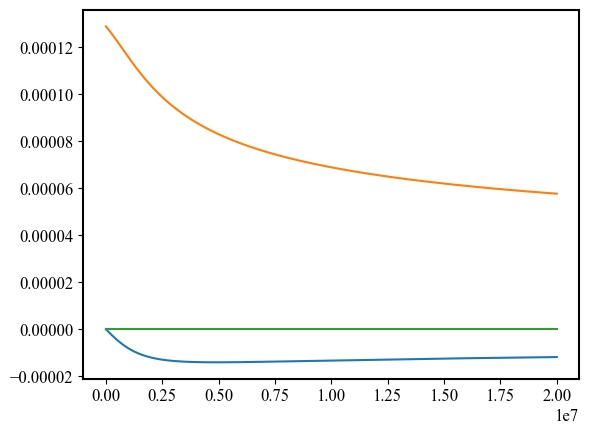

In [37]:
plt.plot(t_eval, v1_df_arr)

In [38]:
# # region code : past for loop
# r1_sol = [r1_initial.copy()]
# r2_sol = [r2_initial.copy()]
# v1_sol = []
# v2_sol = []
# F_D1sol = []
# F_D2sol = []
# r1_mag_sol = []
# r2_mag_sol = []


# for i in range(5):

#     r1, r2, v1, v2, dv1bydt, dv2bydt = two_body(G, m1, m2, r1, r2, v1, v2, delta_t)

#     print(r1, r2)
#     # o = velocity_disp(m_gal)
#     # ln_A1, ln_A2, r1_com_mag, r2_com_mag = coulomb_log(r1, r2, r_com, o, G, m1, m2)


#     # F_D1_accel, F_D2_accel = dynamical_friction(G, m1, m2, r1_com_mag, r2_com_mag, v1, v2, ln_A1, ln_A2, v_com)


#     # dv1bydt += F_D1_accel
#     # dv2bydt += F_D2_accel


#     # v1 += dv1bydt * delta_t
#     # v2 += dv2bydt * delta_t

#     # r1 += v1 * delta_t
#     # r2 += v2 * delta_t


#     r1_mag = np.linalg.norm(r1)
#     r2_mag = np.linalg.norm(r2)

#     r1_mag_sol.append(r1_mag.value)
#     r2_mag_sol.append(r2_mag.value)

#     # F_D1sol.append(F_D1_accel.value)
#     # F_D2sol.append(F_D2_accel.value)

#     r1_sol.append(r1.value)
#     r2_sol.append(r2.value)
#     v1_sol.append(v1.value)
#     v2_sol.append(v2.value)

# time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit

# r1_sol = np.array(r1_sol)
# r2_sol = np.array(r2_sol)
# v1_sol = np.array(v1_sol)
# v2_sol = np.array(v2_sol)
# # F_D1sol = np.array(F_D1sol)
# # F_D2sol = np.array(F_D2sol)
# r1_mag_sol = np.array(r1_mag_sol)
# r2_mag_sol = np.array(r2_mag_sol)



# print("Final positions (r1, r2):", r1_sol[-1], r2_sol[-1])
# print("Final velocities (v1, v2):", v1_sol[-1], v2_sol[-1])
# # print("Final dynamical friction (F_D1, F_D2):", F_D1sol[-1], F_D2sol[-1])

# # endregion     


In [39]:
# region


# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  


# axs[0].plot(time_values, r1_mag_sol, label="|r1|", color='b')

# axs[0].set_title("Magnitude of r1 Over Time")
# axs[0].set_xlabel("Time (Myr)")
# axs[0].set_ylabel("Distance (pc)")
# axs[0].legend()
# axs[0].grid(True)


# axs[1].plot(time_values, r2_mag_sol, label="|r2|", color='r')
# axs[1].set_title("Magnitude of r2 Over Time")
# axs[1].set_xlabel("Time (Myr)")
# axs[1].set_ylabel("Distance (pc)")
# axs[1].legend()
# axs[1].grid(True)

# plt.plot(r1_sol[:, 0], r1_sol[:, 1], label="r1", color='b')
# plt.plot(r2_sol[:, 0], r2_sol[:, 1], label="r2", color='r')
# plt.title("2D Plot of BH A and BH B")

# plt.tight_layout()  # Adjust layout for better spacing
# plt.show()

# # endregion

*mag of velocity + separation vector

In [40]:
# sep = r1_sol - r2_sol
# sep_mag = np.linalg.norm(sep, axis=1)
# print(sep_mag)

# plt.plot(time_values, sep_mag, label="Separation")

In [41]:
# r1_sol = np.array(r1_sol)
# r2_sol = np.array(r2_sol)



# finalsep = r1_sol[-1] - r2_sol[-1]

# print(finalsep)

In [42]:

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')


# ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:, 2], label="Orbit of BH A", color="blue")


# ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:, 2], label="Orbit of BH B", color="red")


# ax.set_xlabel('X (pc)')
# ax.set_ylabel('Y (pc)') 
# ax.set_zlabel('Z (pc)')
# ax.set_title('3D Orbit')


# ax.legend()

# initial_conditions_text = (
#     f"Initial Conditions:\n"
#     f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
#     f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
#     f"Time: 0 to {T}"
# )
# fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# plt.show()

In [43]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.animation import FuncAnimation


# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')


# ax.set_xlabel('X (pc)')
# ax.set_ylabel('Y (pc)')
# ax.set_zlabel('Z (pc)')
# ax.set_title('Orbit Throughout Time')


# line1, = ax.plot([], [], [], label="Orbit of BH A", color="blue")
# line2, = ax.plot([], [], [], label="Orbit of BH B", color="red")
# ax.legend()

# # Limits for the plot (adjust as needed based on data)
# ax.set_xlim([min(np.min(r1_sol[:, 0]), np.min(r2_sol[:, 0])), max(np.max(r1_sol[:, 0]), np.max(r2_sol[:, 0]))])
# ax.set_ylim([min(np.min(r1_sol[:, 1]), np.min(r2_sol[:, 1])), max(np.max(r1_sol[:, 1]), np.max(r2_sol[:, 1]))])
# ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


# def update(num):

#     line1.set_data(r1_sol[:num, 0], r1_sol[:num, 1])
#     line1.set_3d_properties(r1_sol[:num, 2])
    
#     line2.set_data(r2_sol[:num, 0], r2_sol[:num, 1])
#     line2.set_3d_properties(r2_sol[:num, 2])
    
#     return line1, line2

# initial_conditions_text = (
#     f"Initial Conditions:\n"
#     f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
#     f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
#     f"Time: 0 to {T}"
# )
# fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# # ani = FuncAnimation(fig, update, frames=len(r1_sol), interval=50, blit=True)


# # plt.show()


# # ani.save("J1010#6.mp4", writer="ffmpeg", fps=220)  # Adjust fps as needed

Plot of Velocities

Dynamical Friction Plot

In [44]:
# c_values = [0.001, 0.01, 0.1, 1, 10, 100]  

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

# for c in c_values:
#     r1_sol = []
#     r2_sol = []
#     v1_sol = []
#     v2_sol = []
#     F_D1sol = []
#     F_D2sol = []


#     for i in range(N):
#         dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D1)
#         dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D2) 
#         v1 += dv1bydt * delta_t
#         v2 += dv2bydt * delta_t

#         r1 += v1.to(u.pc / u.s) * delta_t
#         r2 += v2.to(u.pc / u.s) * delta_t
#         # region Code Snippet 2: DF
#         r1_com = r1 - r_com
#         r2_com = r2 - r_com

#         r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
#         r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
        

#         o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
#         # region code : Coulomb Logarithm
#         x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
#         x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
#         ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
#         ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
#         # endregion

#         F_D1 = 0.428 * ln_A1 * ((G * m1**(2))/r1_com**(2))
#         F_D2 = 0.428 * ln_A2 * ((G * m2**(2))/r2_com**(2))


#         v_r1 = v1 - v_com 
#         v_r2 = v2 - v_com

#         v_rmag1 = np.sqrt(v_r1[0]**2 + v_r1[1]**2 + v_r1[2]**2)
#         v_rmag2 = np.sqrt(v_r2[0]**2 + v_r2[1]**2 + v_r2[2]**2) #will be doing this from now on though linalg.norm does the same

#         v_rel_unit1 = (v_r1 / v_rmag1)
#         v_rel_unit2 = (v_r2 / v_rmag2)

#         # region code: Dynamical Friction Component to Array for BH A
#         F_D1_i = (F_D1 * -v_rel_unit1[0])
#         F_D1_j = (F_D1 * -v_rel_unit1[1])
#         F_D1_k = (F_D1 * -v_rel_unit1[2])
            
#         F_D1 = np.array([F_D1_i.to((u.kg*u.m)/(u.s**2)).value, F_D1_j.to((u.kg*u.m)/ (u.s**2)).value, F_D1_k.to((u.kg*u.m)/ (u.s**2)).value])
#         # endregion

#         # region code: Dynamical Friction Component to Array for BH B
#         F_D2_i = (F_D2 * -v_rel_unit2[0])
#         F_D2_j = (F_D2 * -v_rel_unit2[1])
#         F_D2_k = (F_D2 * -v_rel_unit2[2])
            
#         F_D2 = np.array([F_D2_i.to((u.kg*u.m)/(u.s**2)).value, F_D2_j.to((u.kg*u.m)/ (u.s**2)).value, F_D2_k.to((u.kg*u.m)/ (u.s**2)).value])
#         # endregion


#         F_D1 = F_D1 * ((u.kg * u.m)/(u.s**2))
#         F_D2 = F_D2 * ((u.kg * u.m)/(u.s**2))
            

#         F_D1 = (F_D1 / m1).to(u.km / u.s**2)
#         F_D2 = (F_D2 / m2).to(u.km / u.s**2)
#         F_D1sol.append([

#             (F_D1_i.to((u.kg * u.m) / (u.s**2))/m1).value,
#             (F_D1_j.to((u.kg * u.m) / (u.s**2))/m1).value,
#             (F_D1_k.to((u.kg * u.m) / (u.s**2))/m1).value
#         ])
#         F_D2sol.append([

#             (F_D2_i.to((u.kg * u.m) / (u.s**2))/m2).value,
#             (F_D2_j.to((u.kg * u.m) / (u.s**2))/m2).value,
#             (F_D2_k.to((u.kg * u.m) / (u.s**2))/m2).value
#         ])

#         r1_sol.append(r1.copy())
#         r2_sol.append(r2.copy())
#         v1_sol.append(v1.copy())
#         v2_sol.append(v2.copy())


#     F_D1sol = np.array(F_D1sol)
#     F_D2sol = np.array(F_D2sol)


#     mag_fd1 = np.sqrt(F_D1sol[:, 0]**2 + F_D1sol[:, 1]**2 + F_D1sol[:, 2]**2)
#     mag_fd2 = np.sqrt(F_D2sol[:, 0]**2 + F_D2sol[:, 1]**2 + F_D2sol[:, 2]**2)


#     axs[0].plot(time_values, mag_fd1, label=f"c = {c}")
#     axs[1].plot(time_values, mag_fd2, label=f"c = {c}")


# axs[0].set_title("Dynamical Friction - Body 1")
# axs[0].set_xlabel("Time (Myr)")
# axs[0].set_ylabel("Force Magnitude (km/s²)")
# axs[0].legend()

# axs[1].set_title("Dynamical Friction - Body 2")
# axs[1].set_xlabel("Time (Myr)")
# axs[1].set_ylabel("Force Magnitude (km/s²)")
# axs[1].legend()

# plt.tight_layout()
# plt.show()

Testing separation levels here

In [45]:
# massterm = (m1+m2)/(10**8*u.Msun)
# velterm = ((200*u.km/u.s)/o)**2
# dynhard_rad = (10*u.pc*massterm*velterm).to(u.pc)
# print(dynhard_rad) #this is the semi-major axis for when stellar hardening takes over from DF (so sep/2)

Pickle

In [46]:
v1_nodf = ((v1_nodf_arr * u.pc / u.yr).to(u.km / u.s)).value
v2_nodf = ((v2_nodf_arr * u.pc / u.yr).to(u.km / u.s)).value
a_grav1_nodf_arr = ((a_grav1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_grav2_nodf_arr = ((a_grav2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df1_nodf_arr = ((a_df1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df2_nodf_arr = ((a_df2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot1_nodf_arr = ((a_tot1_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot2_nodf_arr = ((a_tot2_nodf * u.pc / u.yr**2).to(u.km / u.s**2)).value

v1_df = ((v1_df_arr * u.pc / u.yr).to(u.km / u.s)).value
v2_df = ((v2_df_arr * u.pc / u.yr).to(u.km / u.s)).value
a_grav1_df_arr = ((a_grav1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_grav2_df_arr = ((a_grav2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df1_df_arr = ((a_df1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_df2_df_arr = ((a_df2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot1_df_arr = ((a_tot1_df * u.pc / u.yr**2).to(u.km / u.s**2)).value
a_tot2_df_arr = ((a_tot2_df * u.pc / u.yr**2).to(u.km / u.s**2)).value


In [47]:
data_dict_nodf = {
    "r1": r1_nodf_arr,          
    "r2": r2_nodf_arr,          
    "v1": v1_nodf,          
    "v2": v2_nodf,          
    "sep": sep_nodf_arr,        
    "a_grav1": a_grav1_nodf_arr,    
    "a_grav2": a_grav2_nodf_arr,    
    "a_df1": a_df1_nodf_arr,        
    "a_df2": a_df2_nodf_arr,        
    "a_total1": a_tot1_nodf_arr,    
    "a_total2": a_tot2_nodf_arr,    
    "t": t_eval                 
}


data_dict_df = {
    "r1": r1_df_arr,
    "r2": r2_df_arr,
    "v1": v1_df,
    "v2": v2_df,
    "sep": sep_df_arr,
    "a_grav1": a_grav1_df_arr,
    "a_grav2": a_grav2_df_arr,
    "a_df1": a_df1_df_arr,
    "a_df2": a_df2_df_arr,
    "a_total1": a_tot1_df_arr,
    "a_total2": a_tot2_df_arr,
    "t": t_eval
}

In [48]:
# with open("sim_data_no_df.pkl", "wb") as f:
#     pickle.dump(data_dict_nodf, f)

# with open("sim_data_with_df.pkl", "wb") as f:
#     pickle.dump(data_dict_df, f)